In [1]:
%%HTML
<style> div.output {flex-direction: row} div.output > div:only-child {width: 100%} </style>

In [2]:
import numpy
numpy.set_printoptions(linewidth=numpy.nan)

<img style="margin-left: auto; margin-right: auto; width: 50%" src="uproot-3.png"></img>

What's new?

   * more modularization
   * writing files
   * jagged array operations

## More modularization

uproot 2 had been a single library (optionally depending on lz4).

<img style="margin-left: auto; margin-right: auto; width: 80%" src="abstraction-layers-before.png"></img>

## More modularization

uproot 3 splits out everything that is not I/O. We'll see the advantage in a moment.

<img style="margin-left: auto; margin-right: auto; width: 80%" src="abstraction-layers.png"></img>

## Writing files

uproot can now write histograms to files. It has the same dict-like interface as reading:

In [3]:
import uproot
import numpy

f = uproot.recreate("tmp.root")                                  # instead of uproot.open
f["name"] = numpy.histogram(numpy.random.normal(0, 1, 100000))   # any kind of histogram

In [4]:
f["name"].show()                                                 # read it back out

                          0                                                36362
                          +----------------------------------------------------+
[-inf, -4.8262)     0     |                                                    |
[-4.8262, -3.9238)  3     |                                                    |
[-3.9238, -3.0214)  124   |                                                    |
[-3.0214, -2.119)   1598  |**                                                  |
[-2.119, -1.2166)   9291  |*************                                       |
[-1.2166, -0.31421) 26451 |**************************************              |
[-0.31421, 0.58818) 34630 |**************************************************  |
[0.58818, 1.4906)   21079 |******************************                      |
[1.4906, 2.393)     5955  |*********                                           |
[2.393, 3.2954)     812   |*                                                   |
[3.2954, 4.1977)    57    | 

In [5]:
import ROOT
c = ROOT.TCanvas()

Welcome to JupyROOT 6.14/04


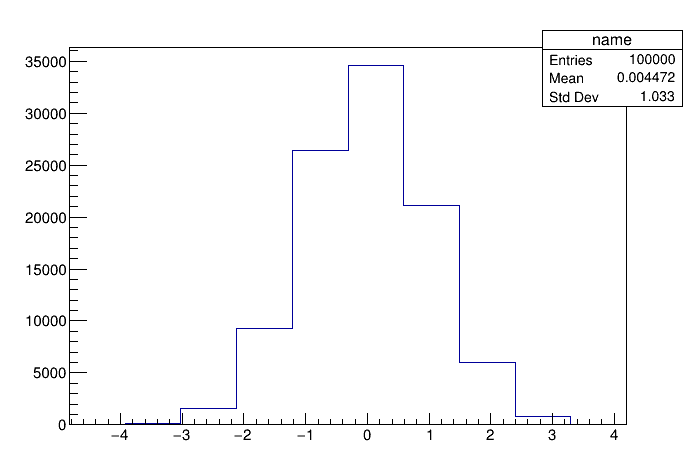

In [6]:
f = ROOT.TFile("tmp.root")                    # ROOT can read it, too
h = f.Get("name")
h.Draw()
c.Draw()

In [7]:
f = ROOT.TFile("tmp.root", "UPDATE")          # ROOT can add to the same file, too
h = ROOT.TH1D("another", "", 10, -5, 5)
for x in numpy.random.normal(0, 1, 100000):
    h.Fill(x)
h.Write()
f.Close()

In [8]:
f = uproot.open("tmp.root")
f["another"].show()

                 0                                                         35737
                 +-------------------------------------------------------------+
[-inf, -5) 0     |                                                             |
[-5, -4)   5     |                                                             |
[-4, -3)   119   |                                                             |
[-3, -2)   2133  |****                                                         |
[-2, -1)   13740 |***********************                                      |
[-1, 0)    34026 |**********************************************************   |
[0, 1)     34035 |**********************************************************   |
[1, 2)     13608 |***********************                                      |
[2, 3)     2224  |****                                                         |
[3, 4)     109   |                                                             |
[4, 5)     1     |          

uproot could become a clearinghouse for histograms from different libraries.

In [9]:
%matplotlib inline
import physt                    # https://physt.readthedocs.io

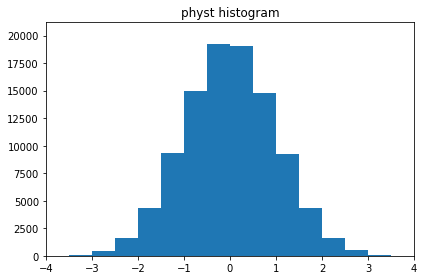

In [10]:
h = physt.h1(numpy.random.normal(0, 1, 100000),
             bins=16, range=(-4, 4), name="physt histogram")
h.plot();

In [11]:
f = uproot.recreate("tmp.root")   # save it as a TH1D
f["name"] = h

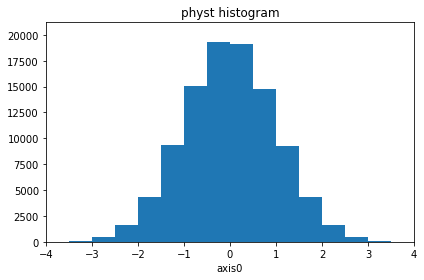

In [12]:
f = uproot.open("tmp.root")       # read it back and convert it back to physt
f["name"].physt().plot();

In [13]:
f["name"].numpy()                  # or numpy

(array([   21,    86,   477,  1649,  4368,  9342, 15015, 19277, 19093, 14760,  9253,  4376,  1626,   508,   118,    24], dtype=int32),
 array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]))

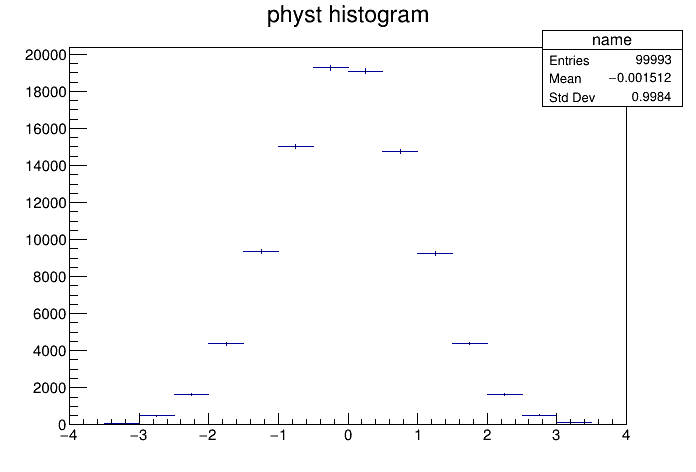

In [14]:
f = ROOT.TFile("tmp.root")         # but look, it's really ROOT
h = f.Get("name")
h.Draw()
c.Draw()

This can also include new ways of looking at histograms.

In [15]:
f = uproot.open("tmp.root")
print(f["name"].hepdata())      # YAML format for the HEPData archival site

dependent_variables:
- header: {name: counts, units: null}
  qualifiers: []
  values:
  - errors:
    - {label: stat, symerror: 4.58257569495584}
    value: 21.0
  - errors:
    - {label: stat, symerror: 9.273618495495704}
    value: 86.0
  - errors:
    - {label: stat, symerror: 21.840329667841555}
    value: 477.0
  - errors:
    - {label: stat, symerror: 40.607881008493905}
    value: 1649.0
  - errors:
    - {label: stat, symerror: 66.09084656743322}
    value: 4368.0
  - errors:
    - {label: stat, symerror: 96.65402216152208}
    value: 9342.0
  - errors:
    - {label: stat, symerror: 122.53570908106747}
    value: 15015.0
  - errors:
    - {label: stat, symerror: 138.84163640637487}
    value: 19277.0
  - errors:
    - {label: stat, symerror: 138.1774221788784}
    value: 19093.0
  - errors:
    - {label: stat, symerror: 121.49074038789952}
    value: 14760.0
  - errors:
    - {label: stat, symerror: 96.19251530134764}
    value: 9253.0
  - errors:
    - {label: stat, symerror: 

This includes an idea I've been working on in which Pandas DataFrames with an interval index _are_ histograms.

In [16]:
f = uproot.open("tmp.root")         # read as histogram
h = f["name"].pandas()
h

,count,variance
physt histogram,,
"[-inf, -4.0)",2,0.0
"[-4.0, -3.5)",21,21.0
"[-3.5, -3.0)",86,86.0
"[-3.0, -2.5)",477,477.0
"[-2.5, -2.0)",1649,1649.0
"[-2.0, -1.5)",4368,4368.0
"[-1.5, -1.0)",9342,9342.0
"[-1.0, -0.5)",15015,15015.0
"[-0.5, 0.0)",19277,19277.0


In [17]:
f = uproot.recreate("tmp.root")     # write as histogram
f["another"] = h

Given the way Pandas handles indexes (interval indexes in particular), Pandas-as-histograms are sparse histograms.

In [18]:
f = uproot.recreate("tmp.root")
f["one"]   = numpy.histogram(numpy.random.normal(1, 0.6, 10000), bins=8, range=(0, 8))
f["two"]   = numpy.histogram(numpy.random.normal(3, 0.4, 10000), bins=8, range=(0, 8))
f["three"] = numpy.histogram(numpy.random.normal(9, 0.6, 100000), bins=8, range=(0, 8))
one   = f["one"].pandas()
two   = f["two"].pandas()
three = f["three"].pandas()

In [19]:
from IPython.display import display
display(one); display(two); display(three);

,count,variance
"[0.0, 1.0)",4568,4568
"[1.0, 2.0)",4483,4483
"[2.0, 3.0)",448,448
"[3.0, 4.0)",4,4


,count,variance
"[1.0, 2.0)",73,73
"[2.0, 3.0)",4893,4893
"[3.0, 4.0)",4980,4980
"[4.0, 5.0)",54,54


,count,variance
"[6.0, 7.0)",45,45
"[7.0, 8.0)",4732,4732


Adding DataFrames matches up intervals and fills in missing values with NaN (0 if we explicitly set it).

In [20]:
import functools
def add(*args):
    return functools.reduce(lambda x, y: x.add(y, fill_value=0), args)

display(add(one, two)); display(add(two, three)); display(add(one, two, three))

,count,variance
"[0.0, 1.0)",4568.0,4568.0
"[1.0, 2.0)",4556.0,4556.0
"[2.0, 3.0)",5341.0,5341.0
"[3.0, 4.0)",4984.0,4984.0
"[4.0, 5.0)",54.0,54.0


,count,variance
"[1.0, 2.0)",73.0,73.0
"[2.0, 3.0)",4893.0,4893.0
"[3.0, 4.0)",4980.0,4980.0
"[4.0, 5.0)",54.0,54.0
"[6.0, 7.0)",45.0,45.0
"[7.0, 8.0)",4732.0,4732.0


,count,variance
"[0.0, 1.0)",4568.0,4568.0
"[1.0, 2.0)",4556.0,4556.0
"[2.0, 3.0)",5341.0,5341.0
"[3.0, 4.0)",4984.0,4984.0
"[4.0, 5.0)",54.0,54.0
"[6.0, 7.0)",45.0,45.0
"[7.0, 8.0)",4732.0,4732.0


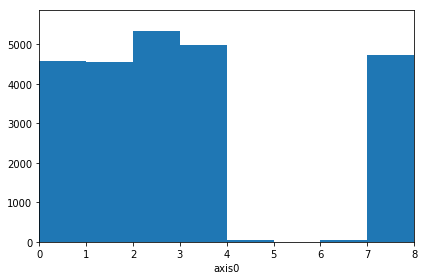

In [21]:
f["all"] = add(one, two, three)
f["all"].physt().plot();

## Modularized file-writing and histogram-conversion

   * all of the histogram-writing code (bytes in file) is in **uproot**
   * all of the code that recognizes different histogram libraries and converts them is in **uproot-methods**

**uproot-methods** can be updated independently of (more rapidly than) **uproot**.

<img style="margin-left: auto; margin-right: auto; width: 70%" src="abstraction-layers.png"></img>

<img style="float: right; width: 40%" src="pratyush.jpg"></img>

## Credit

This feature was developed by Pratyush Das, a DIANA-HEP undergraduate fellow.

(Most of the work was writing _anything_ to a ROOT file; histograms were the last week!)

## Jagged array operations

Also originally part of uproot, split out into **awkward-array** to be generalized and applied beyond ROOT.

<img style="margin-left: auto; margin-right: auto; width: 70%" src="abstraction-layers.png"></img>

Jagged arrays are a minimal unit of nested structure: a list containing lists of varying lengths.

In [22]:
f = uproot.open("HZZ-objects.root")
t = f["events"]

In [23]:
a = t.array("muoniso")
a

<JaggedArray [[4.2001534 2.1510613] [2.1880474] [1.4128217 3.3835042] ... [3.7629452], [0.5508107], [0.]] at 7fa9a9fd1278>

The implementation is a façade: these are not millions of list objects in memory but two arrays with methods to make them _behave like_ nested lists.

In [24]:
a.offsets

array([   0,    2,    3, ..., 3823, 3824, 3825])

In [25]:
a.content

array([4.2001534, 2.1510613, 2.1880474, ..., 3.7629452, 0.5508107, 0.       ], dtype=float32)

In [26]:
for i, x in enumerate(a):
    if i == 20:
        break
    print(i, x)

0 [4.2001534 2.1510613]
1 [2.1880474]
2 [1.4128217 3.3835042]
3 [2.7284882 0.5522966]
4 [0.        0.8563976]
5 [0.        1.4929442]
6 [0.6231756 0.       ]
7 [2.4025257]
8 [0. 0.]
9 [0.        1.7698176]
10 [2.0015755 0.6041591]
11 [0.         0.76338214]
12 [1.7191544]
13 [0.]
14 [0.6410858 1.2613294]
15 [0.        2.0141196]
16 [0.88719386 1.5272698 ]
17 [5.685393]
18 [0.76651436 0.        ]
19 [1.1567837 2.0942292 0.6321085]


Introducing additional types, like "table" as a struct of arrays presented as an array of structs, allows us to make tables of jagged arrays or jagged arrays of tables.

In [75]:
a = t.array("muonp4")
a

<JaggedArrayMethods [[TLorentzVector(-52.899, -11.655, -8.1608, 54.779) TLorentzVector(37.738, 0.69347, -11.308, 39.402)] [TLorentzVector(-0.81646, -24.404, 20.2, 31.69)] [TLorentzVector(48.988, -21.723, 11.168, 54.74) TLorentzVector(0.82757, 29.801, 36.965, 47.489)] ... [TLorentzVector(-29.757, -15.304, -52.664, 62.395)], [TLorentzVector(1.1419, 63.61, 162.18, 174.21)], [TLorentzVector(23.913, -35.665, 54.719, 69.556)]] at 7fa9a507f470>

In [76]:
a.content.content

<Table [<TLorentzVector 0> <TLorentzVector 1> <TLorentzVector 2> ... <TLorentzVector 3822>, <TLorentzVector 3823>, <TLorentzVector 3824>] at 7fa9a547f320>

In [77]:
a.content.content.columns

['fX', 'fY', 'fZ', 'fE']

In [78]:
a[2]["fX"]       # subscript commutativity: hide the AoS ↔ SoA distinction

array([48.98783112,  0.82756668])

In [79]:
a["fX"][2]

array([48.98783112,  0.82756668])

Moreover, we can mix-in methods from **uproot-methods** to objects, arrays, and jagged arrays:

In [32]:
one = a[0][0]; two = a[0][1]; one, two

(TLorentzVector(-52.899, -11.655, -8.1608, 54.779),
 TLorentzVector(37.738, 0.69347, -11.308, 39.402))

In [33]:
one + two

TLorentzVector(-15.162, -10.961, -19.468, 94.181)

In [34]:
(one + two).mass

90.22779776988638

In [35]:
hastwo = (a.counts >= 2); ones = a[hastwo, 0]; twos = a[hastwo, 1]

In [36]:
ones + twos                # the plus "commutes" through the array

<ObjectArrayMethods [TLorentzVector(-15.162, -10.961, -19.468, 94.181) TLorentzVector(49.815, 8.0774, 48.133, 102.23) TLorentzVector(98.78, -99.792, 738.94, 757.5) ... TLorentzVector(22.797, -5.2167, 32.613, 100.43), TLorentzVector(28.806, 16.557, -24.978, 95.018), TLorentzVector(2.9387, 18.416, -261.92, 273.35)] at 7fa9b0f3d5f8>

In [37]:
(ones + twos).mass         # the mass calculation "commutes" through the array

array([90.22779777, 74.74654928, 89.75736376, ..., 92.06495256, 85.44384208, 75.96066262])

I've glossed over an important concept. Let's back up.

<img src="apl-timeline.png" align="right" style="width: 40%"></img>

### Array programming

Expresses regular operations over rectangular data structures in shorthand.

   * Multidimensional slices: `rgb_pixels[0, 50:100, ::3]`
   * Elementwise operations: `all_pz = all_pt * sinh(all_eta)`
   * Broadcasting: `all_phi - 2*pi`
   * Masking: `data[trigger & (pt > 40)]`
   * Fancy indexing: `all_eta[argsort(all_pt)]`
   * Array reduction: `array.sum()` → scalar

Our data are not rectangular, but the syntax can be extended by defining rules for jaggedness.

In [38]:
a2 = a[hastwo]
a2[::2, 0]                         # Multidimensional slices

<ObjectArrayMethods [TLorentzVector(-52.899, -11.655, -8.1608, 54.779) TLorentzVector(22.088, -85.835, 403.85, 413.46) TLorentzVector(9.2281, 40.554, -14.642, 44.093) ... TLorentzVector(74.756, -14.698, -113.75, 136.9), TLorentzVector(53.006, -24.486, 13.952, 60.032), TLorentzVector(34.507, 28.84, -150.66, 157.23)] at 7fa9e8092518>

In [39]:
pt = a.pt; eta = a.eta
pt * numpy.sinh(eta)               # Elementwise operations

<JaggedArray [[ -8.1607933 -11.3075819] [20.19996834] [11.16828537 36.96519089] ... [-52.66374969], [162.17631531], [54.71943665]] at 7fa9e8092048>

In [40]:
multi_per_event = a.phi; one_per_event = t.array("MET").phi
multi_per_event - one_per_event    # Broadcasting

<JaggedArray [[-3.33385136 -0.39073772] [-1.02075184] [-2.99699827 -1.0365802 ] ... [-3.89186587], [2.13301998], [-0.79975049]] at 7fa9e8092e80>

In [41]:
a[a.pt > 40]                       # Masking by jagged (selects particles)

<JaggedArrayMethods [[TLorentzVector(-52.899, -11.655, -8.1608, 54.779)] [] [TLorentzVector(48.988, -21.723, 11.168, 54.74)] ... [], [TLorentzVector(1.1419, 63.61, 162.18, 174.21)], [TLorentzVector(23.913, -35.665, 54.719, 69.556)]] at 7fa9e80925f8>

In [42]:
a[a.pt.max() > 40]                 # Masking by flat (selects events)

<JaggedArrayMethods [[TLorentzVector(-52.899, -11.655, -8.1608, 54.779) TLorentzVector(37.738, 0.69347, -11.308, 39.402)] [TLorentzVector(48.988, -21.723, 11.168, 54.74) TLorentzVector(0.82757, 29.801, 36.965, 47.489)] [TLorentzVector(22.088, -85.835, 403.85, 413.46) TLorentzVector(76.692, -13.956, 335.09, 344.04)] ... [TLorentzVector(-39.286, -14.607, 61.716, 74.603)], [TLorentzVector(1.1419, 63.61, 162.18, 174.21)], [TLorentzVector(23.913, -35.665, 54.719, 69.556)]] at 7fa9a9fa0668>

In [43]:
i = abs(a.eta).argmax()
i

<JaggedArray [[1] [0] [1] ... [0], [0], [0]] at 7fa9e8092630>

In [44]:
a[i]                               # Fancy indexing

<JaggedArrayMethods [[TLorentzVector(37.738, 0.69347, -11.308, 39.402)] [TLorentzVector(-0.81646, -24.404, 20.2, 31.69)] [TLorentzVector(0.82757, 29.801, 36.965, 47.489)] ... [TLorentzVector(-29.757, -15.304, -52.664, 62.395)], [TLorentzVector(1.1419, 63.61, 162.18, 174.21)], [TLorentzVector(23.913, -35.665, 54.719, 69.556)]] at 7fa9e8092470>

In [45]:
abs(a.eta).max()                   # Jagged reduction

array([0.29527553, 0.75381369, 1.0412953 , ..., 1.23504687, 1.66533108, 1.06269886])

In [46]:
import awkward
a = awkward.JaggedArray.fromiter([[   1,     2,    3], [], [    4,    5]])
b = awkward.JaggedArray.fromiter([[  10,    20,   30], [], [   40,   50]])
m = awkward.JaggedArray.fromiter([[True, False, True], [], [False, True]])
flat  = numpy.array([  100,  200,  300])
mflat = numpy.array([False, True, True])
i = awkward.JaggedArray.fromiter([[2, 1], [], [1, 1, 0, 1]])

In [47]:
a + b                              # Elementwise operations

<JaggedArray [[11 22 33] [] [44 55]] at 7fa9e8073ba8>

In [48]:
a + flat                           # Broadcasting

<JaggedArray [[101 102 103] [] [304 305]] at 7fa9e8073128>

In [49]:
a[m]                               # Masking by jagged (selects particles)

<JaggedArray [[1 3] [] [5]] at 7fa9e80738d0>

In [50]:
a[mflat]                           # Masking by flat (selects events)

<JaggedArray [[] [4 5]] at 7fa9e8073240>

In [51]:
a[i]                               # Fancy indexing

<JaggedArray [[3 2] [] [5 5 4 5]] at 7fa9b0f3d2e8>

In [52]:
a.sum()                            # Jagged reduction

array([6, 0, 9])

<img src="logscales.png" style="margin-left: auto; margin-right: auto; width: 90%"></src>

Okay, but what about nested for loops? We want something like a jagged "cross join."

In [53]:
import awkward
a = awkward.JaggedArray.fromiter([[1, 2, 3], [], [4, 5], [6], [7, 8, 9]])
b = awkward.JaggedArray.fromiter([[100, 200], [300], [400], [500, 600, 700], [800, 900]])

In [54]:
a.cross(b)   # .tolist()

<JaggedArray [[<Row 0> <Row 1> <Row 2> <Row 3> <Row 4> <Row 5>] [] [<Row 6> <Row 7>] [<Row 8> <Row 9> <Row 10>] [<Row 11> <Row 12> <Row 13> <Row 14> <Row 15> <Row 16>]] at 7fa9a9fb8d68>

In [55]:
print(a.cross(b)._0)
print(a.cross(b)._1)

[[1 1 2 2 3 3] [] [4 5] [6 6 6] [7 7 8 8 9 9]]
[[100 200 100 200 100 200] [] [400 400] [500 600 700] [800 900 800 900 800 900]]


In [56]:
leptoquarks = t.array("muonp4").cross(t.array("jetp4"))
leptoquarks                                                          # all muon-jet pairs in each event

<JaggedArray [[] [<Row 0>] [] ... [<Row 4057>], [<Row 4058> <Row 4059>], []] at 7fa9a9fb8518>

In [57]:
leptoquarks._0 + leptoquarks._1                                      # the muon in each pair plus the jet in each pair

<JaggedArrayMethods [[] [TLorentzVector(-39.691, -4.5408, 19.305, 75.828)] [] ... [TLorentzVector(-33.472, -52.506, -11.652, 118.35)], [TLorentzVector(-35.219, 73.783, 388.61, 403.79) TLorentzVector(-14.115, 36.434, 174.3, 208.13)], []] at 7fa9a9fb8be0>

In [58]:
(leptoquarks._0 + leptoquarks._1).mass                               # the mass of each pair

<JaggedArray [[] [61.49117266] [] ... [99.96350949], [ 73.10963363 106.82646499], []] at 7fa9a9fb85c0>

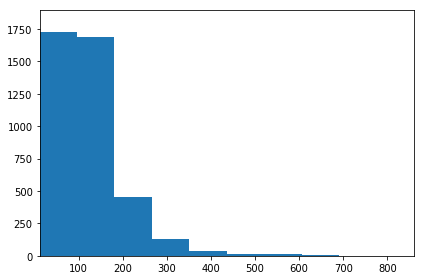

In [59]:
physt.h1((leptoquarks._0 + leptoquarks._1).mass.flatten()).plot();   # a one-line search for leptoquarks

What about nested for loops without duplicates?

In [60]:
import awkward
a = awkward.JaggedArray.fromiter([[], [1], [1, 2], [1, 2, 3], [1, 2, 3, 4]])

In [61]:
a.pairs().tolist()               # same=False

[[],
 [{'0': 1, '1': 1}],
 [{'0': 1, '1': 1}, {'0': 1, '1': 2}, {'0': 2, '1': 2}],
 [{'0': 1, '1': 1},
  {'0': 1, '1': 2},
  {'0': 1, '1': 3},
  {'0': 2, '1': 2},
  {'0': 2, '1': 3},
  {'0': 3, '1': 3}],
 [{'0': 1, '1': 1},
  {'0': 1, '1': 2},
  {'0': 1, '1': 3},
  {'0': 1, '1': 4},
  {'0': 2, '1': 2},
  {'0': 2, '1': 3},
  {'0': 2, '1': 4},
  {'0': 3, '1': 3},
  {'0': 3, '1': 4},
  {'0': 4, '1': 4}]]

In [62]:
zcandidates = t.array("muonp4").pairs(same=False)
(zcandidates._0 + zcandidates._1).mass

<JaggedArray [[90.22779777] [] [74.74654928] ... [], [], []] at 7fa9a5560b70>

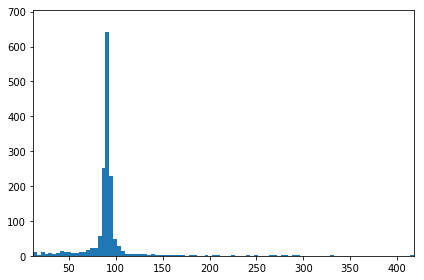

In [63]:
physt.h1((zcandidates._0 + zcandidates._1).mass.flatten(), bins=100).plot();

In [64]:
charges = t.array("muonq").pairs(same=False)
cut = (charges._0 * charges._1 < 0)

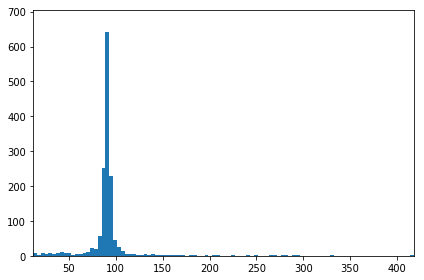

In [65]:
physt.h1((zcandidates[cut]._0 + zcandidates[cut]._1).mass.flatten(), bins=100).plot();

<img style="float: right; width: 10%" src="jaydeep.jpg"></img>

## Credit

Broadcasting, cross, pairs, and a vectorized jagged reduction algorithm were developed by Jaydeep Nandi, a Google Summer of Code student.

None of them involve for loops, not even for loops in C, and are good candidates for GPU acceleration.

<img style="margin-left: auto; margin-right: auto; width: 35%" src="sum_rates_logy.png"></img>

<div style="margin-left: auto; margin-right: auto; width: 70%">
<p>Are there other looping constructs that can't be expressed like this? Which would force you to write a for loop?</p>

<p style="font-weight: bold">Probably.</p>

<p>But when you encounter such instances, let me know and we'll think about new primitives beyond "cross" and "pairs" for those cases.</p>
</div>

Purely for streamlined expression (syntactic sugar), a few higher-order functions have been defined.

   * `array.apply(function)` performs `function(array)`
   * `array.filter(function)` performs `array[function(array)]`
   * `array.maxby(function)` performs `array[function(array).argmax()]`
   * `array.minby(function)` performs `array[function(array).argmin()]`

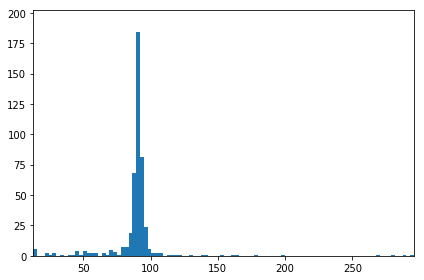

In [74]:
physt.h1(t.array("muonp4")                          # get the muon 4-vectors
          .filter(lambda muon: abs(muon.eta) < 1)   # select central muons (select particles, not events)
          .pairs(same=False)                        # form all non-duplicate pairs
          .apply(lambda a, b: a + b)                # compute Z candidates from as 4-vector sums
          .maxby(lambda z: z.pt)                    # select one per event, the highest pT
          .flatten()                                # flatten [x] → x and [] → nothing (ignore empty events)
          .mass,                                    # compute the masses of what remains
         bins=100).plot();

## Where is this going?

**awkward-array** has been separated out of **uproot** so that it can be extended beyond ROOT files. For instance, we could apply it to data from Spark (through Arrow) and give PySpark users the ability to deal with nested structure efficiently.

   * adding support for other "awkward" array types: chunked, masked, indexed
   * Pandas extensions so that Pandas columns can be "awkward"
   * Numba extensions so you can write fast for loops if you need to
   * Dask extensions so you can distribute work across a cluster